# Chapter 7: Lean Inference
Figures and exercises for Chapter 7 of [Sustainable AI](https://www.oreilly.com/library/view/sustainable-ai/9781098155506/) by Raghavendra Selvan.

**To run locally without errors, clone the entire repository:** 

``` git clone https://github.com/raghavian/sustainable_ai.git ```

## **Section: Lifetime Cost of an AI Model**
### **Figure 7-1.** Training versus inference energy cost trends over a model’s lifetime, where inference costs scale up (left), possibly exceeding the one-time training cost, and lifetime inference costs can easily exceed the one-time training costs (right).

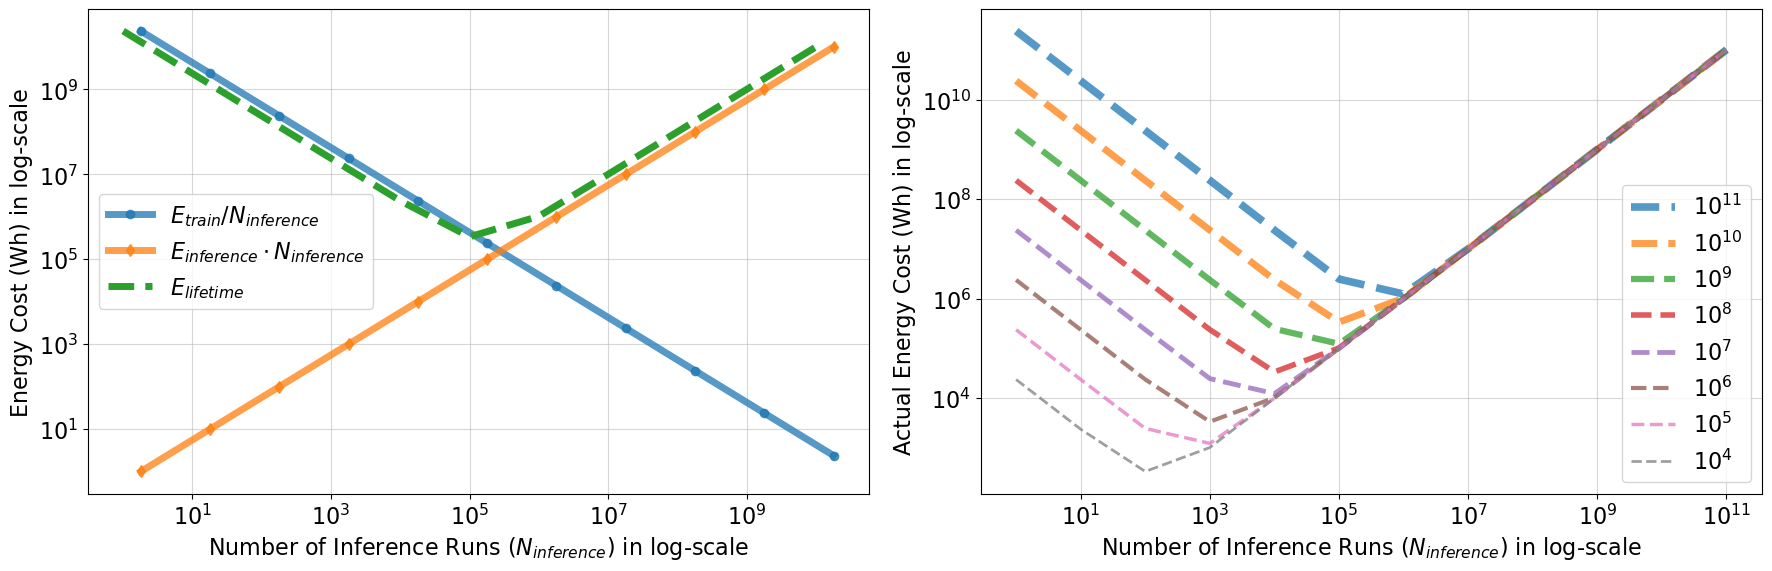

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

params = {'font.size': 16,
          'font.weight': 'normal',
          'axes.labelsize':16,
          'axes.titlesize':16,
          'axes.labelweight':'normal',
          'axes.titleweight':'normal',
          'legend.fontsize': 16,
         }
matplotlib.rcParams.update(params)

### LLama 3 amortized costs
e_train = 30.84e6 * 700 * 1.1 # Llama 3 training cost
e_inf = 1 #Wh

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.yscale('log')
plt.xscale('log')
xrange = 10**(np.arange(0,11))
plt.plot(xrange*1.8,e_train/xrange,'-o',label='$E_{train}/ N_{inference}$',linewidth=5,alpha=0.75)
plt.plot(xrange*1.8,e_inf*xrange,'-d',label='$E_{inference}\cdot N_{inference}$',linewidth=5,alpha=0.75)
plt.plot(xrange,e_inf*xrange + e_train/xrange,'--',label='$E_{lifetime}$',linewidth=5)
plt.grid(alpha=0.5)
plt.xlabel('Number of Inference Runs ($N_{inference}$) in log-scale')
plt.ylabel('Energy Cost (Wh) in log-scale')
plt.legend()


###
#plt.clf()
plt.subplot(122)
plt.yscale('log')
plt.xscale('log')
xrange = 10**(np.arange(0,12))

e_trains = (30.84 * 700 * 1.1 )*10**np.arange(0,8) # Llama 3 training cost
e_inf = 1 #Wh

for e_train in e_trains[::-1]:
    plt.plot(xrange,e_inf*xrange + e_train/xrange,'--',alpha=0.75,linewidth=0.5*np.round(np.log10(e_train)),label='$10^{%d}$'%(np.round(np.log10(e_train))))
    
plt.grid(alpha=0.5)
plt.xlabel('Number of Inference Runs ($N_{inference}$) in log-scale')
plt.ylabel('Actual Energy Cost (Wh) in log-scale')
plt.legend()
plt.tight_layout()

## **Section: Pruning of Trained Models**

### **Example 7-1.** Magnitude pruning can be easily applied to any pretrained model, here shown using the torch_pruning package

Install ```torch_pruning``` package. 

In [ ]:
!pip install torch_pruning

In [2]:
import torch
import timm
import torch_pruning as tp

def prune_model(model, example_inputs, amount=0.5):
    # Define the importance criterion based on L1 norm
    importance = tp.importance.MagnitudeImportance(p=1)

    # Create a pruner object
    iterative_steps = 1 # You can prune your model to the target pruning ratio iteratively.
    pruner = tp.pruner.MagnitudePruner(
            model,
            example_inputs,
            global_pruning=False, # Uniform pruning ratio for all layers.
            importance=importance, # importance criterion for param. selection
            iterative_steps=iterative_steps, # num. of iter. to achieve target ratio
            pruning_ratio=0.5,) 
    # Apply the pruning
    pruner.step()
    return model

# Example input tensor for the ResNet50 model
example_inputs = torch.randn(1, 3, 224, 224)
# Load a pretrained ResNet50 model from Timm
model = timm.create_model('resnet50', pretrained=True)
nParam = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters in base model:%.2fM"%(nParam/1e6))

# Prune the model
pruned_model = prune_model(model, example_inputs, amount=0.5)
nParam = sum(p.numel() for p in pruned_model.parameters() if p.requires_grad)
print("Number of parameters in pruned model:%.2fM"%(nParam/1e6))


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Number of parameters in base model:25.56M
Number of parameters in pruned model:6.41M


### **Example 7-2.** Example showing dynamic quantization of a pretrained model.

In [3]:
import timm
import torch
import torch.quantization
import torch
import os

def check_model_disk_space(model, file_path='temp_model.pth'):
    """
    Saves the model to disk and returns the disk space used by the model.
    """
    # Save the model to disk
    torch.save(model.state_dict(), file_path)
    # Get the size of the file in bytes
    file_size_bytes = os.path.getsize(file_path)
    # Convert bytes to megabytes
    file_size_mb = file_size_bytes / (1024 * 1024)
    # Optionally, remove the temporary file
    os.remove(file_path)
    return file_size_mb

# Example input tensor for the ResNet50 model
# Load a pretrained ResNet50 model from Timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)
nParam = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters in base model:%.2fM"%(nParam/1e6))
model_size=check_model_disk_space(model)
print(f"Model size on disk: {model_size:.2f} MB")

model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)
model_size=check_model_disk_space(model_dynamic_quantized)
nParam = sum(p.numel() for p in model_dynamic_quantized.parameters() if p.requires_grad)
print(f"Quantized model size on disk: {model_size:.2f} MB")



Number of parameters in base model:86.57M
Model size on disk: 330.28 MB
Quantized model size on disk: 85.12 MB


## **Section: Deploying Models**

### **Example 7-3.** Conversion of PyTorch model into ONNX format

In [ ]:
import torch
import timm

# Load a pretrained model or your custom model
model = timm.create_model('resnet18', pretrained=True)
model.eval()  # Set the model to evaluation mode

# Create a dummy input tensor of the correct shape
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model
torch.onnx.export(model, dummy_input, "../output/resnet18.onnx", verbose=True, input_names=['input'], output_names=['output'])

In [11]:
import onnx
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = onnx.load("../output/resnet18.onnx")
onnx.checker.check_model(onnx_model)

# Run inference with ONNX Runtime
ort_session = ort.InferenceSession("../output/resnet18.onnx")

# Prepare input data
dummy_input = np.random.randn(1, 3, 224, 224).astype(np.float32)

# Run the model
outputs = ort_session.run(None, {"input": dummy_input})

# Process the outputs
print(outputs[0].shape)


(1, 1000)


### **Figure 7-8.** Energy consumption of different programming languages (left) and their popularity in 2023 (right) for three standard programming tasks (accessing random sequences, traversing binary trees, and generating random DNA sequences). (Source: based on the results in Pereira et al. “Ranking Programming Languages by Energy Efficiency” [2021].)

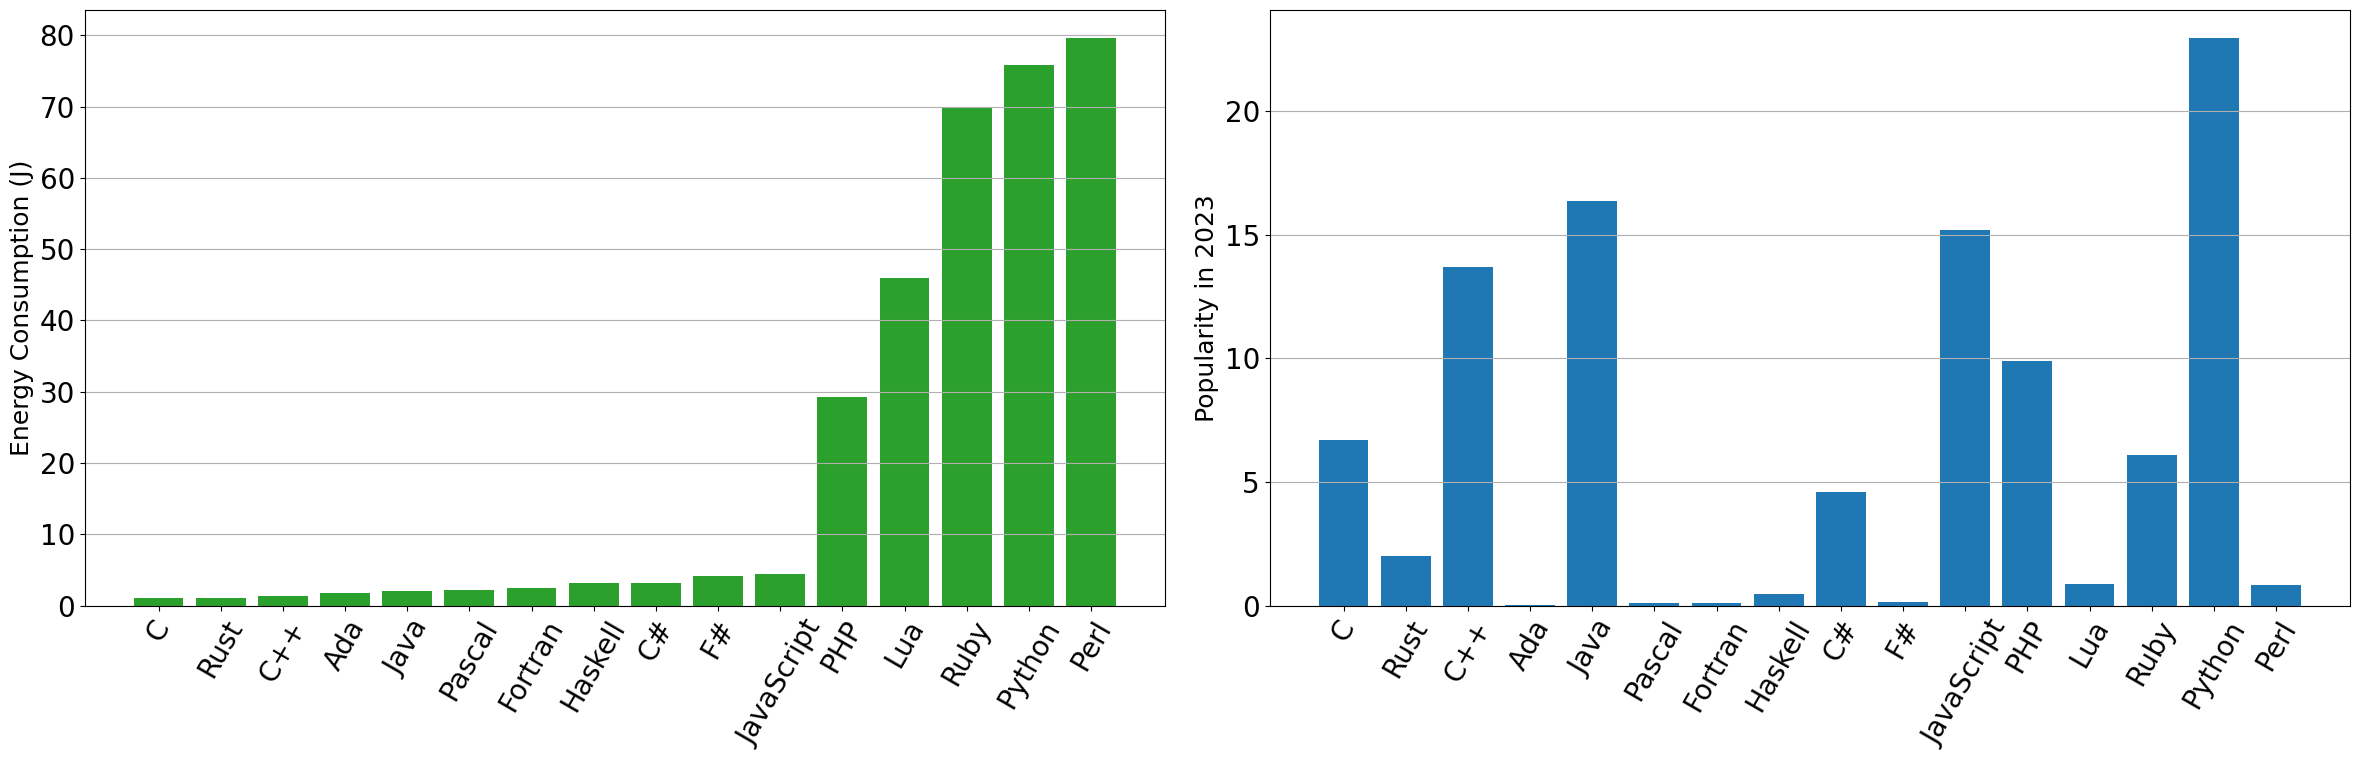

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

params = {'font.size': 20,
          'font.weight': 'normal',
          'axes.labelsize':18,
          'axes.titlesize':18,
          'axes.labelweight':'normal',
          'axes.titleweight':'normal',
          'legend.fontsize': 16,
         }
matplotlib.rcParams.update(params)

### Data for popularity
df = pd.read_csv('../data/ch07_energy_popularity.csv')
# Plot
plt.figure(figsize=(24, 8))
plt.subplot(121)
plt.bar(df['Language'], df['Energy (J)'],color='tab:green')
plt.ylabel('Energy Consumption (J)')
plt.xticks(rotation=60)
plt.grid(axis='y')

plt.subplot(122)
plt.bar(df['Language'], df['count']/df['count'].sum()*100,color='tab:blue')
plt.ylabel('Popularity in 2023')
plt.xticks(rotation=60)
plt.grid(axis='y')

# Show plot
plt.tight_layout()